# 3.6 Regression
Boston housing prices estimation.

## Load data

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [8]:
train_data[33]

array([  1.05393,   0.     ,   8.14   ,   0.     ,   0.538  ,   5.935  ,
        29.3    ,   4.4986 ,   4.     , 307.     ,  21.     , 386.85   ,
         6.58   ])

In [5]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [6]:
train_targets.max()

50.0

In [7]:
train_targets.min()

5.0

## Prepare data
Every sample contains 13 factors which are values from different ranges. Due to this fact, we need to perform standardization of each factor.

In [9]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# standardize with same values as in the training dataset
test_data -= mean
test_data /= std

In [10]:
train_data[33]

array([-0.29159127, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.46844074, -1.4230113 ,  0.37398482, -0.62624905, -0.59517003,
        1.14850044,  0.3411561 , -0.85028847])

## Prepare model
For such small dataset, with only 404 training data samples, we need to prepare small NN model, to avoid overfitting.

In [11]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

As we need to estimate exact price value, our output data layer needs to be simple linear unit. We cannot use the *sigmoid* activation method, because it would result in values in range <0, 1>.

We are using *MSE* - mean square error - as a loss function - it is common method for the regression purpose.

For the accuracy tracking, used metric is the *MAE* - mean absolute error. It is a mean absolute difference between real and predicted value.

## Train with *K cross-validation*
For small datasets, to judge the model corectness, we can perform *K cross-validation* method. It handles the small size of the dataset with changing the validation part of the training dataset.

For example, if *K* is 4, we divide training dataset into 4 smaller parts, and train model 4 times by each time using another part as a validation set.

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
all_scores

[2.403747797012329, 2.3973946571350098, 2.757596969604492, 2.4257798194885254]

In [14]:
np.mean(all_scores)

2.496129810810089

So we achieved mean absolute error = 2,5k USD. Let's try to train for 500 epochs, and visualize MAE during epochs.

In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

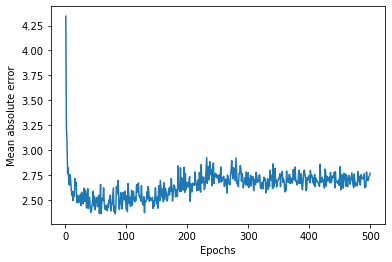

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.show()

Let's skip first 10 epochs and smooth curve with exponential averaging. 

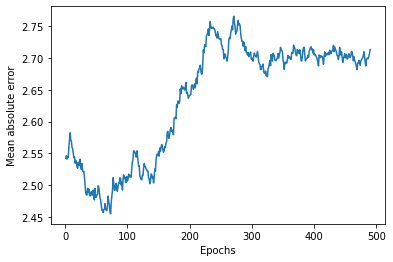

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.show()

In [22]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 2ms/step - loss: 19.3907 - mae: 2.6645


2.6644980907440186

So predicted prices are biased by error around 2,7k USD.

## Summary
- Regression needs another loss function than classification. The common loss is *MSE*.
- It requires another metrics as well. For example, it can be *MAE*.
- If dataset factors are in different ranges, each factor should be normalized.
- While using small dataset, evaluation of the model should be done with cross-validation.
- If we use small dataset, model should be small as well.